In [1]:
import os
import plaid
import requests
import datetime
import json
import pandas as pd
import plotly.express as px
%matplotlib inline

In [2]:
def pretty_print_response(response):
  print(json.dumps(response, indent=4, sort_keys=True))

In [3]:
PLAID_CLIENT_ID = os.getenv('PLAID_CLIENT_ID')
PLAID_SBX_SECRET_KEY = os.getenv('PLAID_SBX_SECRET_KEY')
PLAID_PUBLIC_KEY = os.getenv('PLAID_PUBLIC_KEY')
INSTITUTION_ID = "ins_109508"

# Plaid Access Token

In this section, you will use the plaid-python api to generate the correct authentication tokens to access data in the free developer Sandbox. This mimics how you might connect to your own account or a customer account, but due to privacy issues, this homework will only require connecting to and analyzing the fake data from the developer sandbox that Plaid provides. 

Complete the following steps to generate an access token:
1. Create a client to connect to plaid
2. Use the client to generate a public token and request the following items: 
['transactions', 'income', 'assets']
3. Exchange the public token for an access token
4. Test the access token by requesting and printing the available test accounts

### 1. Create a client to connect to plaid

In [4]:
# api-key = 'tjhwakjgfhkasjdhfsajdflsj$$$'
# api_request = 'https://www.plaid.com/api/'

client = plaid.Client(client_id=PLAID_CLIENT_ID, 
                     secret=PLAID_SBX_SECRET_KEY,
                     public_key=PLAID_PUBLIC_KEY,
                     environment='sandbox')

### 2. Generate a public token

In [5]:
create_tkn = client.Sandbox.public_token.create(INSTITUTION_ID, ['transactions','income','assets'])

### 3. Exchange the public token for an access token

In [6]:
exchange_tkn = client.Item.public_token.exchange(create_tkn['public_token'])
access_tkn = exchange_tkn['access_token']

### 4. Fetch Accounts

In [7]:
accounts = client.Accounts.get(access_tkn)
pretty_print_response(accounts)

{
    "accounts": [
        {
            "account_id": "jovEbGyyBGI7EL6LlkBJIB4bWkDVy3f17P8jX",
            "balances": {
                "available": 100,
                "current": 110,
                "iso_currency_code": "USD",
                "limit": null,
                "unofficial_currency_code": null
            },
            "mask": "0000",
            "name": "Plaid Checking",
            "official_name": "Plaid Gold Standard 0% Interest Checking",
            "subtype": "checking",
            "type": "depository"
        },
        {
            "account_id": "7roqp4ZZ74HA3VeVjbmWhoZpxGyJ9vsg5RKaW",
            "balances": {
                "available": 200,
                "current": 210,
                "iso_currency_code": "USD",
                "limit": null,
                "unofficial_currency_code": null
            },
            "mask": "1111",
            "name": "Plaid Saving",
            "official_name": "Plaid Silver Standard 0.1% Interest Saving",
       

---

# Account Transactions with Plaid

In this section, you will use the Plaid Python SDK to connect to the Developer Sandbox account and grab a list of transactions. You will need to complete the following steps:


1. Use the access token to fetch the transactions for the last 90 days
2. Print the categories for each transaction type
3. Create a new DataFrame using the following fields from the JSON transaction data: `date, name, amount, category`. (For categories with more than one label, just use the first category label in the list)
4. Convert the data types to the appropriate types (i.e. datetimeindex for the date and float for the amount)

### 1. Fetch the Transactions for the last 90 days

In [29]:
start_date = f'{datetime.datetime.now() + datetime.timedelta(-90):%Y-%m-%d}'
end_date = f'{datetime.datetime.now():%Y-%m-%d}' 
transactions_response = client.Transactions.get(access_tkn, start_date, end_date)
transactions = transactions_response['transactions']

### 2. Print the categories for each transaction

In [31]:
categories =[]
for t in transactions: 
    category = t['category']
    categories.append(category)
    print(category)

['Travel', 'Taxi']
['Food and Drink', 'Restaurants']
['Payment']
['Food and Drink', 'Restaurants', 'Fast Food']
['Shops', 'Sporting Goods']
['Payment', 'Credit Card']
['Travel', 'Taxi']
['Transfer', 'Debit']
['Transfer', 'Deposit']
['Recreation', 'Gyms and Fitness Centers']
['Travel', 'Airlines and Aviation Services']
['Food and Drink', 'Restaurants', 'Fast Food']
['Food and Drink', 'Restaurants', 'Coffee Shop']
['Food and Drink', 'Restaurants']
['Transfer', 'Credit']
['Travel', 'Airlines and Aviation Services']
['Travel', 'Taxi']
['Food and Drink', 'Restaurants']
['Payment']
['Food and Drink', 'Restaurants', 'Fast Food']
['Shops', 'Sporting Goods']
['Payment', 'Credit Card']
['Travel', 'Taxi']
['Transfer', 'Debit']
['Transfer', 'Deposit']
['Recreation', 'Gyms and Fitness Centers']
['Travel', 'Airlines and Aviation Services']
['Food and Drink', 'Restaurants', 'Fast Food']
['Food and Drink', 'Restaurants', 'Coffee Shop']
['Food and Drink', 'Restaurants']
['Transfer', 'Credit']
['Travel'

### 3. Create a new DataFrame using the following fields from the JSON transaction data: date, name, amount, category. 

(For categories with more than one label, just use the first category label in the list)

In [32]:
trans_data_df = pd.DataFrame(columns=['Date','Category','Vendor','Amount'])
for index, t in enumerate(transactions):
    trans_data_df.loc[index] = [t['date'], 
                              t['category'][0], 
                              t['name'], 
                              t['amount']]
trans_data_df.head()

,Date,Category,Vendor,Amount
0,2020-01-29,Travel,Uber,6.33
1,2020-01-26,Food and Drink,Tectra Inc,500.00
2,2020-01-25,Payment,AUTOMATIC PAYMENT - THANK,2078.50
3,2020-01-25,Food and Drink,KFC,500.00
4,2020-01-25,Shops,Madison Bicycle Shop,500.00


### 4. Convert the data types to the appropriate types 

(i.e. datetimeindex for the date and float for the amount)

In [33]:
trans_data_df['Amount'].astype(float)
trans_data_df['Date'] = pd.to_datetime(trans_data_df['Date'])
trans_data_df.dtypes

Date        datetime64[ns]
Category            object
Vendor              object
Amount             float64
dtype: object

---

# Income Analysis with Plaid

In this section, you will use the Plaid Sandbox to complete the following:
1. Determine the previous year's gross income and print the results
2. Determine the current monthly income and print the results
3. Determine the projected yearly income and print the results

In [34]:
income_response = client.Income.get(access_tkn)
income = income_response['income']
gross_last_year = income['last_year_income_before_tax']
print(f"Previous year's gross income: {gross_last_year}")
current_monthly_income = income['income_streams'][0]['monthly_income']
print(f"Current monthly income: {current_monthly_income}")
gross_projected_year = income['projected_yearly_income_before_tax']
print(f"Projeceted yearly gross income: {gross_projected_year}")

Previous year's gross income: 7285
Current monthly income: 500
Projeceted yearly gross income: 7389


---

# Budget Analysis
In this section, you will use the transactions DataFrame to analyze the customer's budget

1. Calculate the total spending per category and print the results (Hint: groupby or count transactions per category)
2. Generate a bar chart with the number of transactions for each category 
3. Calculate the expenses per month
4. Plot the total expenses per month

### Calculate the expenses per category

                  Amount
Category                
Food and Drink   3317.19
Payment          6310.50
Recreation        235.50
Shops            1500.00
Transfer        20537.34
Travel             35.19


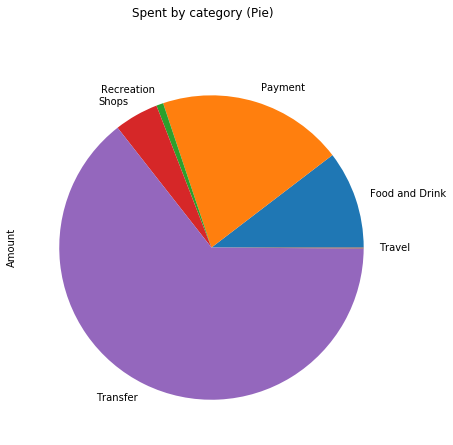

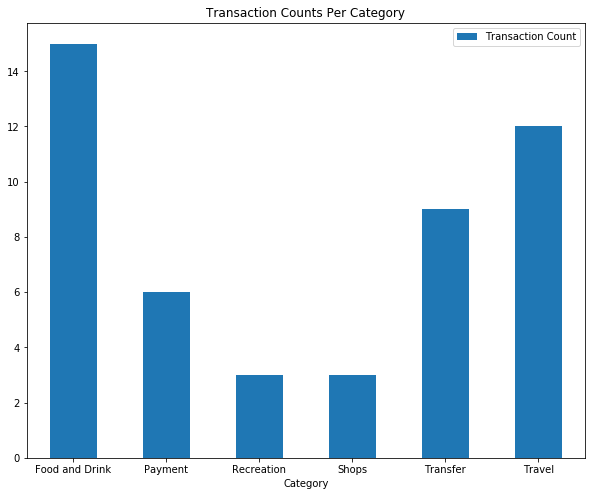

In [68]:
total_spent_by_category = trans_data_df.groupby('Category').sum()
print(total_spent_by_category)
total_spent_by_category['Amount'].plot.pie(subplots=True, 
                               title='Spent by category (Pie)', 
                               figsize=(10,7))
total_count_by_category = trans_data_df.filter(['Category','Amount']).groupby(['Category']).count()
total_count_by_category.columns = ['Transaction Count']
total_count_by_category.plot.bar(rot=360, title="Transaction Counts Per Category", 
                                 figsize=(10,8))

### Calculate the expenses per month

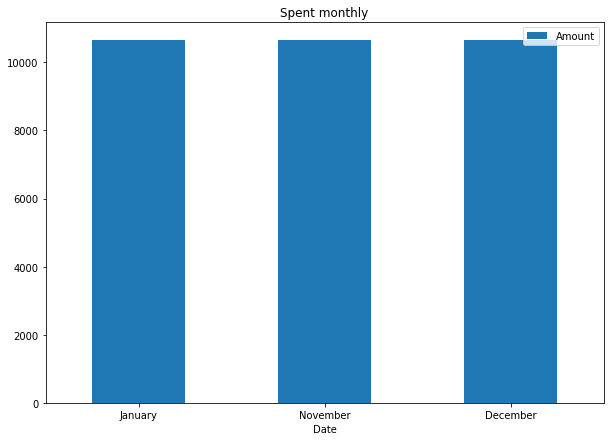

In [59]:
# trans_data_df.set_index('Date', inplace=True)
monthly_trans_df = trans_data_df.groupby(trans_data_df.index.month).sum()
monthly_trans_df.rename(index={1:'January',
                        11:'November',
                        12:'December'}, inplace=True)
monthly_trans_df.plot.bar(rot=360,title='Spent monthly', figsize=(10,7))

In [65]:
num_monthly_trans_df = trans_data_df.groupby(trans_data_df.index.month).count()
num_monthly_trans_df.rename(index={1:'January',
                        11:'November',
                        12:'December'}, inplace=True)


grouped_count

,Transaction Count
Category,
Food and Drink,15
Payment,6
Recreation,3
Shops,3
Transfer,9
Travel,12
